In [2]:
from spamdfba import toolkit as tk
from spamdfba import toymodels as tm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import os
import warnings
import rich
import multiprocessing as mp
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2023-11-15 21:52:20,746	INFO worker.py:1642 -- Started a local Ray instance.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-17


In [3]:
NUM_CORES = 8
warnings.filterwarnings("ignore")


## Toy-Exoenzyme-Single-Agent

This toy community is designed to emulate a case that microbial cells are grown on a mixture of starch and glucose in a chemostat with a very low dilution rate of 0.0001, practically a batch system, Figure 3A-C, The strains are capable of secreting amylase to degrade the available starch. However, producing amylase is an energy-consuming step in the organism’s metabolism and it requires ATP that would otherwise be used in biomass production. 

First, we need to define the agents. The agents need a metabolic model (cobra model) which is defined in Toy_Model.py. The agents
also need a name, a neural network class, not instance as a pytorch module, clip which shows the threshold for clipping the gradients, and a learning rate. you also need to define what environment states you want your agent to sense and also what is the actions that the agents can take. Look below for an example of defining an agent.
additionally, you can look at toolkit.py for more information on defining agents.

As the first case, we consider only one agent in the system:

![Single-agent](./single_agent.png)




In [27]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]


Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpxba5i644.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


After defining the agents, we need to define the environment. The environment needs a list of agents, inictial conditions and a dictionary representing extracellular reactions as well as the duration of an episode and the time resoloution of the DFBA algorithm. More information on defining the environment can be found in toolkit.py. Look below for an example of defining the environment.

In [28]:
env_1=tk.Environment(name="Toy-Exoenzyme-Single-agents",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=5000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


Now we can start the training loop. The training loop needs the environment, the number of episodes, the number of steps per episode, and the number of steps for each gradient update. The training loop will return the rewards for each episode and the average reward for each episode. Look below for an example of training loop.

In [29]:
sim_1=tk.Simulation(name=env_1.name,
                  env=env_1,
                  save_dir="./Results/",
                  )

In [36]:
sim_1.run(verbose=False)

In [32]:
fig_single_agent=sim_1.plot_learning_curves(plot=False)

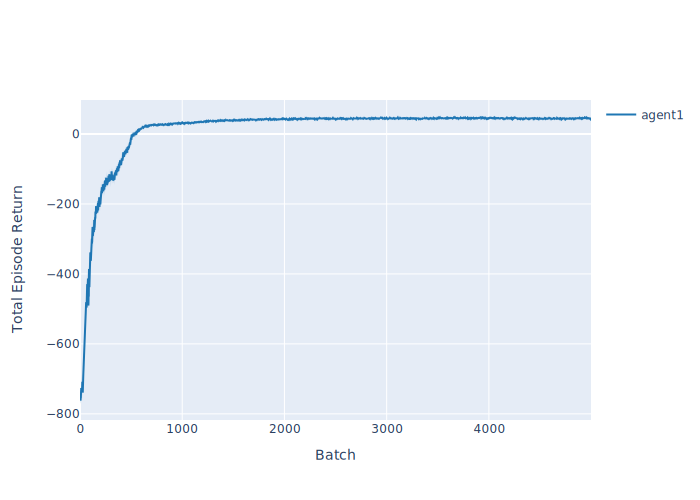

In [34]:
fig_single_agent.show(renderer="svg")

In [35]:
fig_single_agent.write_html(env_1.name+"_learning_curve.html")

In [24]:
time_single_agent=sim_1.print_training_times()

                        Simulation times                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Level        ┃ Mean(s)               ┃ STD(s)                ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Optimization │ 0.0003498440815448762 │ 6.495468274710666e-05 │
│ Step         │ 0.0005561942130148409 │ 9.948172783878535e-05 │
│ Batch        │ 1.192914434671402     │ 0.20728934267366944   │
│ Simulation   │ 6135.182281970978     │ NA                    │
└──────────────┴───────────────────────┴───────────────────────┘

In [25]:
with open(env_1.name+"_Runtime.json","w") as f:
    json.dump(time_single_agent,f)

## Toy-Exoenzyme-Two-Agent
This environment is similar to the previous environment but it has two independent agent that are similar in terms of metabolic capabilities.

![Two-agents](./Two_agents.png)

In [41]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agent2=tk.Agent("agent2",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2', 'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1,agent2]

env_2=tk.Environment(name="Toy-Exoenzyme-Two-agents",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"agent2":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                           dt=0.1,
                           number_of_batches=5000,
                           episodes_per_batch=int(NUM_CORES/2),
                           )



Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmphkr_pxbk.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpw9r7mhgv.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


The following species are not in the community: ['Starch']


In [42]:
sim_2=tk.Simulation(name=env_2.name,
                  env=env_2,
                  save_dir="./Results/",
                  )


In [45]:
sim_2.run(verbose=False)

In [46]:
fig_two_agents=sim_2.plot_learning_curves(plot=False)

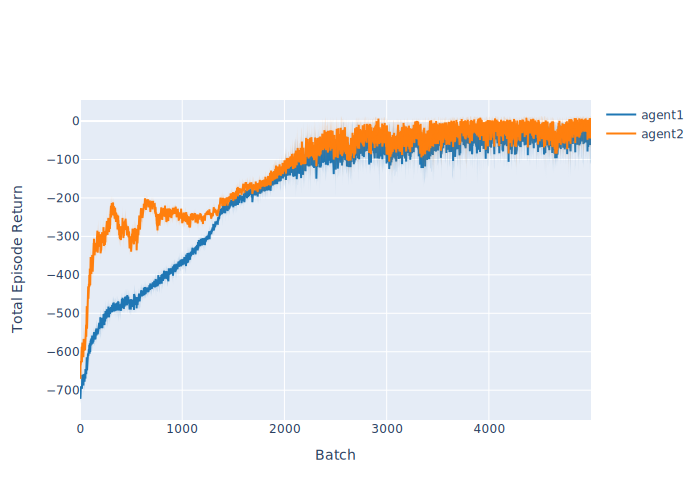

In [47]:
fig_two_agents.show(renderer="svg")

In [48]:
fig_two_agents.write_html(env_2.name+"_learning_curve.html")

In [29]:
time_two_agent=sim_2.print_training_times()

                        Simulation times                         
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Level        ┃ Mean(s)               ┃ STD(s)                 ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Optimization │ 0.0004752251323282723 │ 6.358572031670175e-05  │
│ Step         │ 0.0014352515552341965 │ 0.00018915827331749974 │
│ Batch        │ 3.0117019214630125    │ 0.4198159922654137     │
│ Simulation   │ 15380.066538095474    │ NA                     │
└──────────────┴───────────────────────┴────────────────────────┘

In [30]:
with open(env_2.name+"_Runtime.json","w") as f:
    json.dump(time_two_agent,f)

## Toy-Exoenzyme-Five-Agents

This example expands the number of agents to 5. Otherwise, it is similar to the previous cases.

![Two-agents](./Five_agents.png)

In [5]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5','Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agent2=tk.Agent("agent2",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5', 'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agent3=tk.Agent("agent3",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5', 'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )
agent4=tk.Agent("agent4",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5', 'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )
agent5=tk.Agent("agent5",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5', 'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1,agent2,agent3,agent4,agent5]


env_5=tk.Environment(name="Toy-Exoenzyme-Five-agents",
                  agents=agents,
                  dilution_rate=0.0001,
                  initial_condition={"Glc":100,"agent1":0.1,"agent2":0.1,"agent3":0.1,"agent4":0.1,"agent5":0.1,"Starch":10},
                  inlet_conditions={"Starch":10},
                  extracellular_reactions=[{"reaction":{
                      "Glc":10,
                  "Starch":-0.1,},
                  "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                         dt=0.1,
                         number_of_batches=5000,
                         episodes_per_batch=int(NUM_CORES/2),
                         )                 

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmp3z81um8n.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpsul8el_w.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmppceivrt6.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmp07nu68ye.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpbdk8cqzc.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


The following species are not in the community: ['Starch']


In [6]:
sim_5=tk.Simulation(name=env_5.name,
                  env=env_5,
                  save_dir="./Results/",
                  )

In [1]:
sim_5.run(verbose=False)

In [10]:
fig_five_agents=sim_5.plot_learning_curves(plot=False)

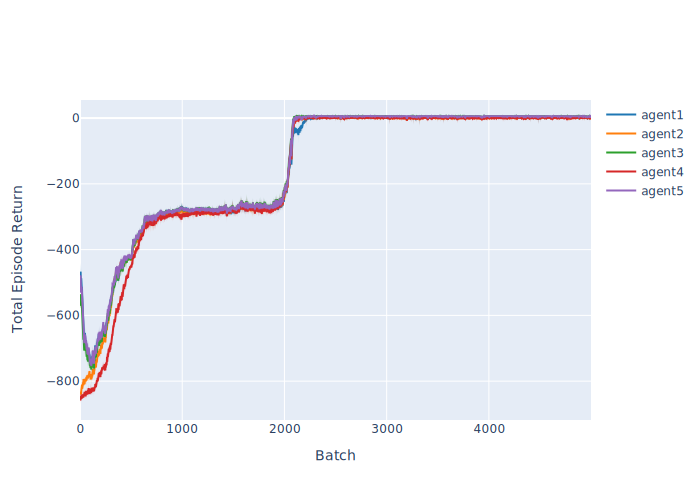

In [11]:
fig_five_agents.show(renderer="svg")

In [12]:
fig_five_agents.write_html(env_5.name+"_learning_curve.html")

In [44]:
time_five_agents=sim_5.print_training_times()

                        Simulation times                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Level        ┃ Mean(s)               ┃ STD(s)                ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Optimization │ 0.0005903975674891481 │ 0.0031956770080609547 │
│ Step         │ 0.0039366018775641946 │ 0.01599821661863543   │
│ Batch        │ 8.383434451341628     │ 31.841009360363014    │
│ Simulation   │ 42710.0100312233      │ NA                    │
└──────────────┴───────────────────────┴───────────────────────┘

In [42]:
with open(env_5.name+"_Runtime.json","w") as f:
    json.dump(time_five_agents,f)

## Simulation Times

Now it would be interesting to see how the simulation times change by adding agents to the system

In [13]:
agents=[1,2,5]
optimization=[0.00034, 0.00047,0.00059]
step=[0.00055,0.00143,0.00393]
batch=[1.19,3.01,8.38]
simulation=[6135.18,15380.06,42710.01]

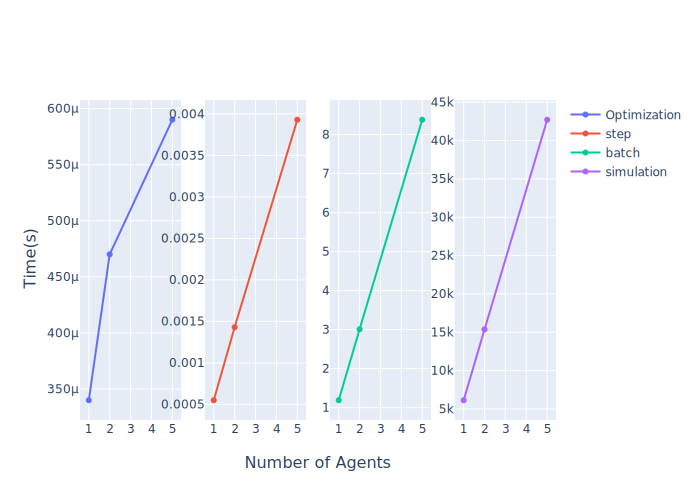

In [16]:
fig = make_subplots(rows=1, cols=4,x_title='Number of Agents',
                    y_title='Time(s)',)

fig.add_trace(
    go.Scatter(x=agents, y=optimization,name="Optimization"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=agents, y=step,name="step"),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=agents, y=batch,name="batch"),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(x=agents, y=simulation,name="simulation"),
    row=1, col=4
)
fig.show(renderer="svg")

In [15]:
fig.write_html("./Results/Runtime_comp.html")

## Toy-Exoenzyme-Five-Agents-with-mass-transfer

In corporation spacial information in to the current model could be challenging. However, we can simulate a simple case of mass transfer using a trick. Right now, an environment object can include any arbitrary extracellular reactions with an arbitrary kinetics. The way we incorporated mass transfer effect is just to qualitatively see how microbial strategies will change depending on the rate of mass transfer. In this approach, each agent is surrounded by a specific compartment. An agent directly exchange the metabolites of interest with its compartment. The compartments then exchange materials with the shared metabolite pool through a defined exchange reaction with an arbitrary kinetics. In this case the rate of these "reactions" are defined by K*(Ca-Cs), where K is a mass transfer coefficient for the compound in the given environment. Ca represents the concentration of the metabolite in the agent's compartment and Cs represents the concentration of the same compound in the shared compartment: Agent x produces amylase_x and releases it to its compartment. amylase_x degrades starch to glucose_x. glucose_x now can be exchanged with the surroundings through an imaginary reaction glucose_x. In this way, the products that are produced by agent_x will be released to the environment according to a kinetic rather than being instantaneous. In the starch amylase case this could be beneficial to the agent as the broken down glucose won't be available to other agents as fast! The main advantage of this method is that it requires no change in the code! 

In [22]:

toy_model_1=tm.ToyModel_SA_1.copy()
toy_model_2=tm.ToyModel_SA_2.copy()
toy_model_3=tm.ToyModel_SA_3.copy()
toy_model_4=tm.ToyModel_SA_4.copy()
toy_model_5=tm.ToyModel_SA_5.copy()


agent1=tk.Agent("agent1",
                model=toy_model_1,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5' ,'Glc_1', 'Starch'],
                actions=["Amylase_1_e"],
                gamma=1,
                )

agent2=tk.Agent("agent2",
                model=toy_model_2,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1','agent2','agent3','agent4','agent5' ,'Glc_2', 'Starch'],
                actions=["Amylase_2_e"],
                gamma=1,
                )



agent3=tk.Agent("agent3",
                model=toy_model_3,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
				observables=['agent1','agent2','agent3','agent4','agent5' ,'Glc_3', 'Starch'],
                actions=["Amylase_3_e"],
                gamma=1,
)

agent4=tk.Agent("agent4",
                model=toy_model_4,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
				observables=['agent1','agent2','agent3','agent4','agent5' ,'Glc_4', 'Starch'],
                actions=["Amylase_4_e"],
                gamma=1,
)

agent5=tk.Agent("agent5",
                model=toy_model_5,
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=10,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
				observables=['agent1','agent2','agent3','agent4','agent5' ,'Glc_5', 'Starch'],
                actions=["Amylase_5_e"],
                gamma=1,
)

agents=[agent1,agent2,agent3,agent4,agent5]

env_mt=tk.Environment(name="Toy-Exoenzyme-Five-agents-mass-transfer-low",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":0,"Glc_1":20,"Glc_2":20,"Glc_3":20,"Glc_4":20,"Glc_5":20,"agent1":0.1,"agent2":0.1,'agent3':0.1,'agent4':0.1,'agent5':0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc_1":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase_1"))} ### The trick
		            ,
		            {
                    "reaction":{
                    "Glc_2":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase_2")) ### The trick
                    ,}
		    ,
		    {
                    "reaction":{
                    "Glc_3":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase_3")) ### The trick
		    
            },
            {
                    "reaction":{
                    "Glc_4":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase_4")) ### The trick
                    
            },  
	    
            {   "reaction":{
                    "Glc_5":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase_5")) ### The trick
                    
            }  ,
            {   
                "reaction":{
                    "Glc_1":-1,
                    "Glc":1},
                "kinetics": (tk.mass_transfer,("Glc_1","Glc"))    ### The trick
            }
            ,
            {
                "reaction":{
                    "Glc_2":-1,
                    "Glc":1},
                "kinetics": (tk.mass_transfer,("Glc_2","Glc")) ### The trick
            }
            ,
            {
                "reaction":{
                    "Glc_3":-1,
                    "Glc":1},
                "kinetics": (tk.mass_transfer,("Glc_3","Glc"))  ### The trick
            },
            {
                "reaction":{
                    "Glc_4":-1,
                    "Glc":1},
                "kinetics": (tk.mass_transfer,("Glc_4","Glc"))  ### The trick
            }
            ,
            {
                "reaction":{ 
                    "Glc_5":-1,
                    "Glc":1},
                "kinetics": (tk.mass_transfer,("Glc_5","Glc"))   ### The trick
            }
					],
                           dt=0.1,
                           number_of_batches=5000,
                           episodes_per_batch=int(NUM_CORES/2),
                           )


Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmp7nsh05g5.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpjaepibv_.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpv19_peys.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpcdw2dwer.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros
Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpoc2ylq5m.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


The following species are not in the community: ['Starch', 'Starch', 'Starch', 'Starch', 'Starch', 'Glc', 'Glc', 'Glc', 'Glc', 'Glc']


In [23]:
sim_mt=tk.Simulation(name=env_mt.name,
                  env=env_mt,
                  save_dir="./Results/",
                  )

In [90]:
sim_mt.run(verbose=False)

In [27]:
fig_mt=sim_mt.plot_learning_curves(plot=False)

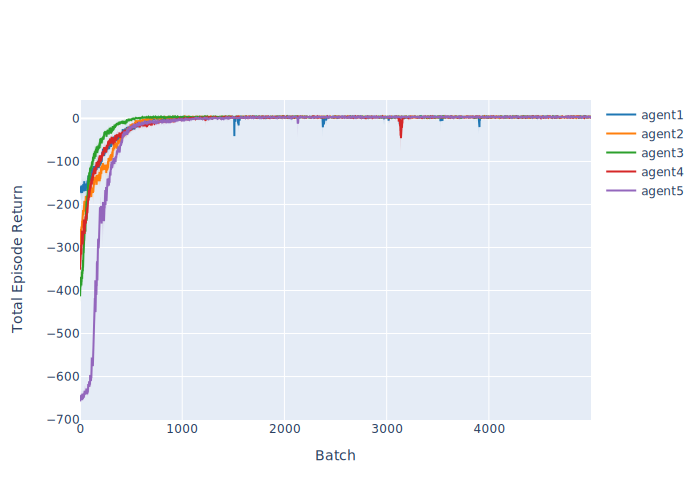

In [28]:
fig_mt.show(renderer="svg")

In [29]:
fig_mt.write_html("five_agents_mass.html")

In [85]:
sim_mt.print_training_times()

                         Simulation times                         
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Level        ┃ Mean(s)                ┃ STD(s)                 ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Optimization │ 0.00037325048970222484 │ 4.803991405943705e-05  │
│ Step         │ 0.0027956058902746488  │ 0.00033150853508638866 │
│ Batch        │ 2.220130316600024      │ 0.17401675099580874    │
│ Simulation   │ 12040.851713001215     │ NA                     │
└──────────────┴────────────────────────┴────────────────────────┘

[{'mean': 0.0027956058902746488, 'std': 0.00033150853508638866},
 {'mean': 0.00037325048970222484, 'std': 4.803991405943705e-05},
 {'mean': 2.220130316600024, 'std': 0.17401675099580874},
 {'mean': 12040.851713001215, 'std': 1.8191713297756002e-12}]

## Hyperparameter Selection

Similar to most reinforcement learning problems, hyper parameters play a significant role in the training performance. The design of SPAM-DFBA fascilitates exploring the hyperparameter search. In the following section is about seeing the effect of some of the hyperparameters on the training performance

### Gradient clipping threshold

This parameter is defined at the time of defining an agent and specifies to clip the gradient values that exceed a certain value. Let's start with a small value for the clip parameters. The overal pattern we expect is that increasing the clipping threshold will decrease the convergence time while increasing the learning instability.


In [4]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.05,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=4,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmptqrhle85.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [5]:
env_1_low_clip=tk.Environment(name="Toy-Exoenzyme-Single-agents_low_clip",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [6]:
sim_1_low_clip=tk.Simulation(name=env_1_low_clip.name,
                  env=env_1_low_clip,
                  save_dir="./Results/",
                  )

In [28]:
sim_1_low_clip.run(verbose=False)

In [14]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=4,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmp1i3g6z82.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [15]:
env_1_med_clip=tk.Environment(name="Toy-Exoenzyme-Single-agents_med_clip",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [16]:
sim_1_med_clip=tk.Simulation(name=env_1_med_clip.name,
                  env=env_1_med_clip,
                  save_dir="./Results/",
                  )

In [27]:
sim_1_med_clip.run(verbose=False)

In [18]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=4,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpnl7k2e6z.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [19]:
env_1_high_clip=tk.Environment(name="Toy-Exoenzyme-Single-agents_high_clip",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [20]:
sim_1_high_clip=tk.Simulation(name=env_1_high_clip.name,
                  env=env_1_high_clip,
                  save_dir="./Results/",
                  )

In [26]:
sim_1_high_clip.run(verbose=False)

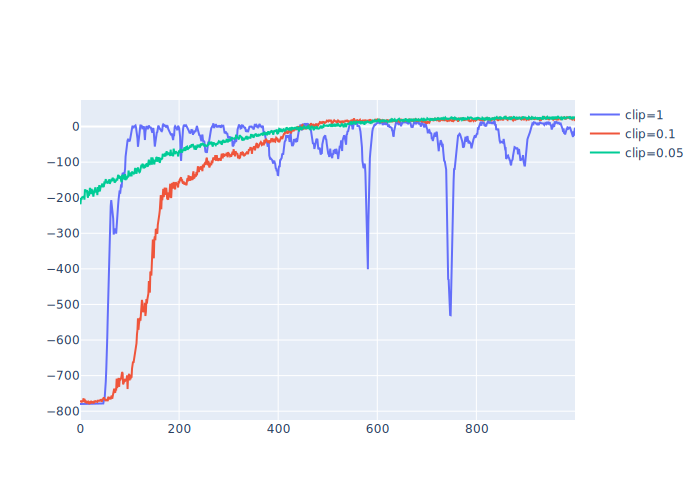

In [25]:
fig_clip=go.Figure()
data_high=np.array(sim_1_high_clip.report["returns"]["agent1"]).mean(axis=1)
fig_clip.add_trace(
    go.Scatter(
        x=list(range(data_high.shape[0])),
        y=data_high,
        name="clip=1"
    )
)
data_med=np.array(sim_1_med_clip.report["returns"]["agent1"]).mean(axis=1)
fig_clip.add_trace(
    go.Scatter(
        x=list(range(data_med.shape[0])),
        y=data_med,
        name="clip=0.1"
    )
)
data_low=np.array(sim_1_low_clip.report["returns"]["agent1"]).mean(axis=1)
fig_clip.add_trace(
    go.Scatter(
        x=list(range(data_low.shape[0])),
        y=data_low,
        name="clip=0.05"
    )
)
fig_clip.show(renderer="svg")

In [29]:
fig_clip.write_html("clip.html")

As we can see large clip value reduces the stability while causes the return to increase quickly

In [33]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=1,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmporrjr8_4.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [34]:
env_low_grad_step=tk.Environment(name="Toy-Exoenzyme-Single-agents_low_grad_steps",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [35]:
sim_1_low_grad_step=tk.Simulation(name=env_low_grad_step.name,
                  env=env_low_grad_step,
                  save_dir="./Results/",
                  )

In [56]:
sim_1_low_grad_step.run(verbose=False)

In [41]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=5,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpld42w4p8.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [42]:
env_med_grad_step=tk.Environment(name="Toy-Exoenzyme-Single-agents_med_grad_steps",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [43]:
sim_med_grad_step=tk.Simulation(name=env_med_grad_step.name,
                  env=env_med_grad_step,
                  save_dir="./Results/",
                  )

In [55]:
sim_med_grad_step.run(verbose=False)

In [50]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.0001,
                lr_critic=0.001,
                grad_updates=20,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpw1srprgn.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [51]:
env_high_grad_step=tk.Environment(name="Toy-Exoenzyme-Single-agents_high_grad_steps",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [52]:
sim_high_grad_step=tk.Simulation(name=env_high_grad_step.name,
                  env=env_high_grad_step,
                  save_dir="./Results/",
                  )

In [54]:
sim_high_grad_step.run(verbose=False)

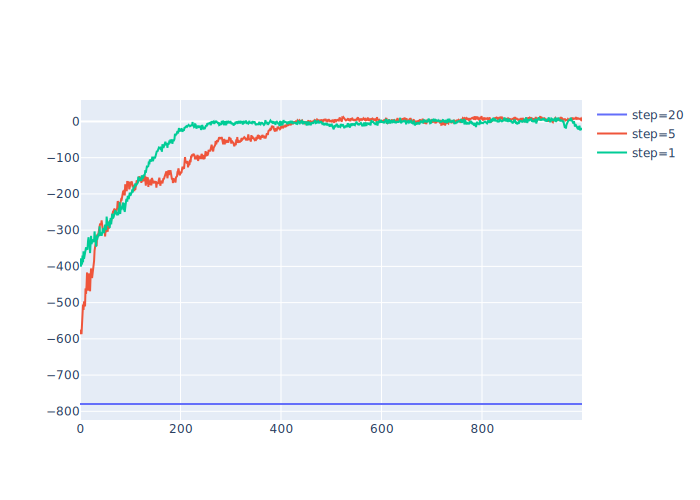

In [58]:
fig_grad_step=go.Figure()
data_high=np.array(sim_high_grad_step.report["returns"]["agent1"]).mean(axis=1)
fig_grad_step.add_trace(
    go.Scatter(
        x=list(range(data_high.shape[0])),
        y=data_high,
        name="step=20"
    )
)
data_med=np.array(sim_med_grad_step.report["returns"]["agent1"]).mean(axis=1)
fig_grad_step.add_trace(
    go.Scatter(
        x=list(range(data_med.shape[0])),
        y=data_med,
        name="step=5"
    )
)
data_low=np.array(sim_1_low_grad_step.report["returns"]["agent1"]).mean(axis=1)
fig_grad_step.add_trace(
    go.Scatter(
        x=list(range(data_low.shape[0])),
        y=data_low,
        name="step=1"
    )
)
fig_grad_step.show(renderer="svg")

In [59]:
fig_grad_step.write_html("gradient_step.html")

We see that increasing the gradient decent steps increases the stability and also the total return for 1000 episodes

In [64]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.001,
                lr_critic=0.001,
                grad_updates=20,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmp0ibvnbrs.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [65]:
env_med_lr=tk.Environment(name="Toy-Exoenzyme-Single-agents_med_lr",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [66]:
sim_med_lr=tk.Simulation(name=env_med_lr.name,
                  env=env_med_lr,
                  save_dir="./Results/",
                  )

In [89]:
sim_med_lr.run(verbose=False)

In [68]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.01,
                lr_critic=0.001,
                grad_updates=20,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpx6rq_lby.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [69]:
env_high_lr=tk.Environment(name="Toy-Exoenzyme-Single-agents_high_lr",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [70]:
sim_high_lr=tk.Simulation(name=env_high_lr.name,
                  env=env_high_lr,
                  save_dir="./Results/",
                  )

In [88]:
sim_high_lr.run(verbose=False)

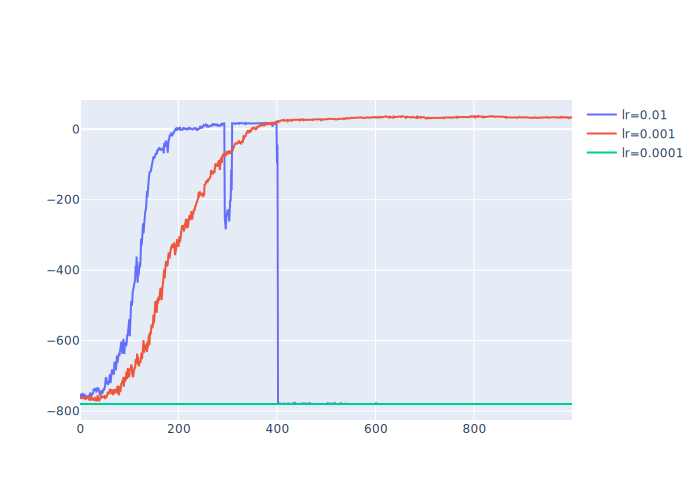

In [72]:
fig_actor_learning=go.Figure()
data_high=np.array(sim_high_lr.report["returns"]["agent1"]).mean(axis=1)
fig_actor_learning.add_trace(
    go.Scatter(
        x=list(range(data_high.shape[0])),
        y=data_high,
        name="lr=0.01"
    )
)
data_med=np.array(sim_med_lr.report["returns"]["agent1"]).mean(axis=1)
fig_actor_learning.add_trace(
    go.Scatter(
        x=list(range(data_med.shape[0])),
        y=data_med,
        name="lr=0.001"
    )
)
data_low=np.array(sim_high_grad_step.report["returns"]["agent1"]).mean(axis=1)
fig_actor_learning.add_trace(
    go.Scatter(
        x=list(range(data_low.shape[0])),
        y=data_low,
        name="lr=0.0001"
    )
)
fig_actor_learning.show(renderer="svg")

In [73]:
fig_actor_learning.write_html("lr.html")

From the above plot we see that increasing the learning rates beyond a certain point will destabilize the learning process. On the other hand, very low learning rate could lead to slow to no learning

### Effect of Actor Variance on the learning process

This hyperparametr is very important as it balances exploration vs exploitation. Expect very low variance to be less noisy but slower in convergence while higher variance will be more noisy and faster in convergence

In [74]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.001,
                lr_critic=0.001,
                grad_updates=20,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                actor_var=0.001,
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpplz04jtn.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [75]:
env_low_var=tk.Environment(name="Toy-Exoenzyme-Single-agents_low_var",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [76]:
sim_low_var=tk.Simulation(name=env_low_var.name,
                  env=env_low_var,
                  save_dir="./Results/",
                  )

In [87]:
sim_low_var.run(verbose=False)

In [78]:
agent1=tk.Agent("agent1",
                model=tm.ToyModel_SA.copy(),
                actor_network=tk.NN,
                critic_network=tk.NN,
                clip=0.1,
                lr_actor=0.001,
                lr_critic=0.001,
                grad_updates=20,
                optimizer_actor=torch.optim.Adam,
                optimizer_critic=torch.optim.Adam,
                observables=['agent1' ,'Glc', 'Starch'],
                actions=["Amylase_e"],
                actor_var=1,
                gamma=1,
                )

agents=[agent1]

Read LP format model from file /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/tmpzxeu5xy2.lp
Reading time = 0.00 seconds
: 7 rows, 18 columns, 44 nonzeros


In [79]:
env_high_var=tk.Environment(name="Toy-Exoenzyme-Single-agents_high_var",
                    agents=agents,
                    dilution_rate=0.0001,
                    initial_condition={"Glc":100,"agent1":0.1,"Starch":10},
                    inlet_conditions={"Starch":10},
                    extracellular_reactions=[{"reaction":{
                    "Glc":10,
                    "Starch":-0.1,},
                    "kinetics": (tk.general_kinetic,("Starch","Amylase"))}],
                     dt=0.1,
                     number_of_batches=1000,
                     episodes_per_batch=int(NUM_CORES/2),)

The following species are not in the community: ['Starch']


In [80]:
sim_high_var=tk.Simulation(name=env_high_var.name,
                  env=env_high_var,
                  save_dir="./Results/",
                  )

In [86]:
sim_high_var.run(verbose=False)

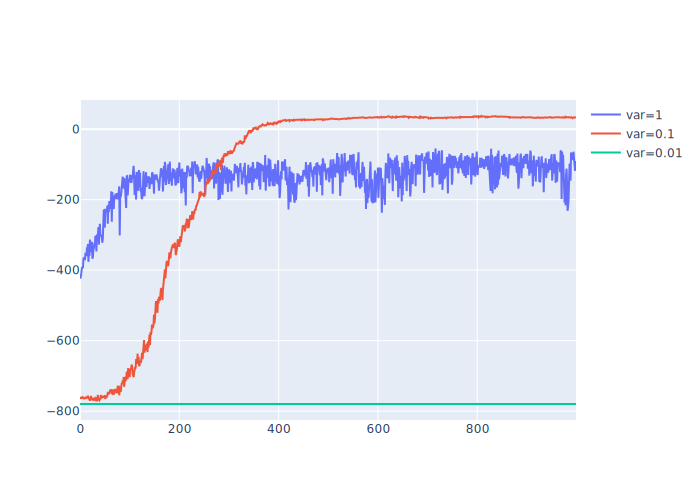

In [84]:
fig_actor_var=go.Figure()
data_high=np.array(sim_high_var.report["returns"]["agent1"]).mean(axis=1)
fig_actor_var.add_trace(
    go.Scatter(
        x=list(range(data_high.shape[0])),
        y=data_high,
        name="var=1"
    )
)
data_med=np.array(sim_med_lr.report["returns"]["agent1"]).mean(axis=1)
fig_actor_var.add_trace(
    go.Scatter(
        x=list(range(data_med.shape[0])),
        y=data_med,
        name="var=0.1"
    )
)
data_low=np.array(sim_low_var.report["returns"]["agent1"]).mean(axis=1)
fig_actor_var.add_trace(
    go.Scatter(
        x=list(range(data_low.shape[0])),
        y=data_low,
        name="var=0.01"
    )
)
fig_actor_var.show(renderer="svg")

Here we see that very low actor variance causes low exploration and basically no learning in this case. High variance does good in the beginning but because of more noise in behavior achieves less return on average (Also high variance increases the chance of going to infeasible region).

In [85]:
fig_actor_var.write_html("actor_var.html")